In [11]:
import argparse
import torch
import time
import numpy as np
from rdkit import RDLogger

lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

from torch.nn import MSELoss
from bondnet.data.dataset import ReactionNetworkDataset
from bondnet.data.dataloader import DataLoaderReactionNetwork
from bondnet.data.featurizer import (
    AtomFeaturizerMinimum,
    AtomFeaturizerFull,
    BondAsNodeFeaturizerMinimum,
    GlobalFeaturizer,
    BondAsNodeFeaturizerFull,
)
from bondnet.data.grapher import HeteroMoleculeGraph
from bondnet.data.dataset import train_validation_test_split
from bondnet.model.gated_reaction_network import GatedGCNReactionNetwork
from bondnet.scripts.create_label_file import read_input_files
from bondnet.model.metric import WeightedL1Loss
from bondnet.prediction.load_model import load_dataset, load_model
from bondnet.utils import seed_torch
from torchsummary import summary

# Aug 10


In [4]:
import torch
import time, wandb
import numpy as np
from tqdm import tqdm
from sklearn.metrics import r2_score
from torchmetrics import R2Score
from torch.optim.lr_scheduler import ReduceLROnPlateau

from bondnet.model.metric import EarlyStopping
from bondnet.data.dataset import ReactionNetworkDatasetGraphs
from bondnet.data.dataloader import DataLoaderReactionNetwork
from bondnet.data.dataset import train_validation_test_split

# from bondnet.scripts.create_label_file import read_input_files
# from bondnet.model.metric import WeightedL1Loss, WeightedMSELoss
from bondnet.utils import seed_torch, pickle_dump, parse_settings
from bondnet.model.training_utils import (
    evaluate,
    evaluate_classifier,
    train,
    train_classifier,
    load_model,
    evaluate_r2,
    get_grapher,
)

seed_torch()

/home/santiagovargas/anaconda3/envs/bondnet/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
best = 1e10
feature_names = ["atom", "bond", "global"]
path_mg_data = "../dataset/mg_dataset/"
dict_train = parse_settings(file="settings.txt")
path_mg_data = "../../../dataset/mg_dataset/20220613_reaction_data.json"

using the following settings:
----------------------------------------
Small Dataset?: False
restore: True
distributed: False
on gpu: False
num gpu: 1
hyperparam save file: ./hyper.pkl
dataset state dict: home/santiagovargas/Documents/Dataset/mg/dataset_state_dict.pkl
model dir /home/santiagovargas/Documents/Dataset/mg/
classifier False
batch size: 256
epochs: 100
lr: 0.000100
weight decay: 0.000
early_stop: True
scheduler: True
transfer_epochs: 100
transfer: False
loss: False
categories: 3
embedding size: 24
fc layers: 2
fc hidden layer: [128, 64]
gated layers: 3
gated hidden layers: [64, 64, 64]
num lstm iters: 6
num lstm layer: 3
gated fc layers: 2
fc activation: ReLU
fc batch norm: 0
fc dropout: 0.00
gated activation: ReLU
gated dropout: 0.10
gated batch norm: True
gated graph norm: 0
gated resid: True
----------------------------------------


In [6]:
if dict_train["classifier"]:
    classif_categories = 5  # update this later
else:
    classif_categories = None

if dict_train["on_gpu"]:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dict_train["gpu"] = device
else:
    device = torch.device("cpu")
    dict_train["gpu"] = "cpu"

print("train on device: {}".format(dict_train["gpu"]))

train on device: cpu


In [7]:
path_mg_data = "../dataset/mg_dataset/20220613_reaction_data.json"

dataset = ReactionNetworkDatasetGraphs(
    grapher=get_grapher(),
    file=path_mg_data,
    out_file="./",
    target="ts",
    classifier=dict_train["classifier"],
    classif_categories=classif_categories,
    debug=dict_train["debug"],
    device=device,
)

dataset_transfer = ReactionNetworkDatasetGraphs(
    grapher=get_grapher(),
    file=path_mg_data,
    out_file="./",
    target="diff",
    classifier=dict_train["classifier"],
    classif_categories=classif_categories,
    debug=dict_train["debug"],
    device=device,
)

reading file from: ../dataset/mg_dataset/20220613_reaction_data.json
rxn raw len: 3001
Program finished in 14.417848569999478 seconds
.............failures.............
reactions len: 550
valid ind len: 550
bond break fail count: 		0
default fail count: 		2451
sdf map fail count: 		0
product bond fail count: 	0
about to group and organize
number of grouped reactions: 550


*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders



features: 1372
labels: 550
molecules: 1372
constructing graphs & features....
Valence of atom 0 is 5 which bigger than allowed max 4 . Stopping
Valence of atom 0 is 5 which bigger than allowed max 4 . Stopping
Valence of atom 1 is 5 which bigger than allowed max 4 . Stopping
Valence of atom 1 is 5 which bigger than allowed max 4 . Stopping
number of graphs valid: 1372
number of graphs: 1372
reading file from: ../dataset/mg_dataset/20220613_reaction_data.json
rxn raw len: 3001
Program finished in 14.515308740999899 seconds
.............failures.............
reactions len: 550
valid ind len: 550
bond break fail count: 		0
default fail count: 		2451
sdf map fail count: 		0
product bond fail count: 	0
about to group and organize
number of grouped reactions: 550


*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders



features: 1372
labels: 550
molecules: 1372
constructing graphs & features....
Valence of atom 0 is 5 which bigger than allowed max 4 . Stopping
Valence of atom 0 is 5 which bigger than allowed max 4 . Stopping
Valence of atom 1 is 5 which bigger than allowed max 4 . Stopping
Valence of atom 1 is 5 which bigger than allowed max 4 . Stopping
number of graphs valid: 1372
number of graphs: 1372


In [8]:
for it, (bg, label) in enumerate(train_loader):
    print(bg.device)

cuda:0


In [6]:
import numpy as np
import torch, wandb
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torchmetrics import F1Score

from bondnet.model.metric import WeightedL1Loss, WeightedMSELoss
from bondnet.model.gated_reaction_network import GatedGCNReactionNetwork
from bondnet.model.gated_reaction_network_classifier import (
    GatedGCNReactionNetworkClassifier,
)

In [8]:
dict_train["in_feats"] = dataset.feature_size
model, optimizer, optimizer_transfer = load_model(dict_train)
model.to(device)

trainset, valset, testset = train_validation_test_split(
    dataset, validation=0.15, test=0.15
)

train_loader = DataLoaderReactionNetwork(
    trainset, batch_size=dict_train["batch_size"], shuffle=True
)
val_loader = DataLoaderReactionNetwork(valset, batch_size=len(valset), shuffle=False)
test_loader = DataLoaderReactionNetwork(testset, batch_size=len(testset), shuffle=False)

scheduler = ReduceLROnPlateau(
    optimizer, mode="min", factor=0.4, patience=25, verbose=True
)
stopper = EarlyStopping(patience=150)
stopper_transfer = EarlyStopping(patience=150)

if True:
    trainset_transfer, valset_tranfer, _ = train_validation_test_split(
        dataset_transfer, validation=0.15, test=0.01
    )
    dataset_transfer_loader = DataLoaderReactionNetwork(
        trainset_transfer, batch_size=dict_train["batch_size"], shuffle=True
    )
    dataset_transfer_loader_val = DataLoaderReactionNetwork(
        valset_tranfer, batch_size=dict_train["batch_size"], shuffle=True
    )

    print("Initiating Training w/ transfer...")
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("Number of Trainable Model Params: {}".format(params))

    for epoch in tqdm(range(dict_train["transfer_epochs"])):
        if dict_train["classifier"]:
            _, _ = train_classifier(
                model,
                feature_names,
                dataset_transfer_loader,
                optimizer,
                device=dict_train["gpu"],
                categories=classif_categories,
            )
            val_acc_transfer, f1_score = evaluate_classifier(
                model,
                feature_names,
                dataset_transfer_loader_val,
                device=dict_train["gpu"],
                categories=classif_categories,
            )
        else:
            _, _ = train(
                model,
                feature_names,
                dataset_transfer_loader,
                optimizer,
                device=dict_train["gpu"],
            )
            val_acc_transfer = evaluate(
                model,
                feature_names,
                dataset_transfer_loader_val,
                device=dict_train["gpu"],
            )

        if stopper_transfer.step(val_acc_transfer):
            break

    # freeze model layers but fc
    model.gated_layers.requires_grad_(False)
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("Freezing Gated Layers....")
    print("Number of Trainable Model Params: {}".format(params))

t1 = time.time()
# optimizer, loss function and metric function
# main training loop
if dict_train["classifier"]:
    print("# Epoch     Loss         TrainAcc        ValAcc        ValF1")
else:
    print("# Epoch     Loss         TrainAcc        ValAcc        ValR2")

for epoch in range(dict_train["epochs"]):
    # train on training set
    if dict_train["classifier"]:
        loss, train_acc = train_classifier(
            model,
            feature_names,
            train_loader,
            optimizer,
            device=dict_train["gpu"],
            categories=classif_categories,
        )

        # evaluate on validation set
        val_acc, f1_score = evaluate_classifier(
            model,
            feature_names,
            val_loader,
            device=dict_train["gpu"],
            categories=classif_categories,
        )

        wandb.log({"acc validation": val_acc})
        wandb.log({"f1 validation": f1_score})
        print(
            "{:5d}   {:12.6e}   {:12.2e}   {:12.6e}   {:.2f}".format(
                epoch, loss, train_acc, val_acc, f1_score
            )
        )

    else:
        loss, train_acc = train(
            model, feature_names, train_loader, optimizer, dict_train["gpu"]
        )
        # evaluate on validation set
        val_acc = evaluate(model, feature_names, val_loader, dict_train["gpu"])
        val_r2 = evaluate_r2(model, feature_names, val_loader)

        print(
            "{:5d}   {:12.6e}   {:12.2e}   {:12.6e}   {:.2f}".format(
                epoch, loss, train_acc, val_acc, val_r2
            )
        )

    # save checkpoint for best performing model
    is_best = val_acc < best
    if is_best:
        best = val_acc
        torch.save(model.state_dict(), "checkpoint.pkl")

    if dict_train["early_stop"]:
        if stopper.step(val_acc):
            pickle_dump(
                best, dict_train["save_hyper_params"]
            )  # save results for hyperparam tune
            break
    scheduler.step(val_acc)

checkpoint = torch.load("checkpoint.pkl")
model.load_state_dict(checkpoint)

if dict_train["classifier"]:
    test_acc, test_f1 = evaluate_classifier(
        model,
        feature_names,
        test_loader,
        device=dict_train["gpu"],
        categories=classif_categories,
    )
    print("Test Acc: {:12.6e}".format(test_acc))
    print("Test F1: {:12.6e}".format(test_f1))


else:
    test_acc = evaluate(model, feature_names, test_loader)
    print("TestAcc: {:12.6e}".format(test_acc))

t2 = time.time()
print("Time to Training: {:5.1f} seconds".format(float(t2 - t1)))

Initiating Training w/ transfer...
Number of Trainable Model Params: 378177


100%|██████████| 100/100 [04:59<00:00,  2.99s/it]


Freezing Gated Layers....
Number of Trainable Model Params: 282625
# Epoch     Loss         TrainAcc        ValAcc        ValR2
    0   5.838395e-01       5.86e-01   7.375593e-01   -0.05
    1   5.697868e-01       5.87e-01   7.308374e-01   -0.05
    2   5.829880e-01       5.71e-01   7.175438e-01   -0.04
    3   5.574794e-01       5.58e-01   7.077865e-01   -0.00
    4   5.375884e-01       5.28e-01   7.008233e-01   0.02
    5   5.129869e-01       5.16e-01   6.963155e-01   0.04
    6   5.009432e-01       5.09e-01   6.927217e-01   0.05
    7   5.023253e-01       5.01e-01   6.913143e-01   0.05
    8   4.861548e-01       4.94e-01   6.868426e-01   0.06
    9   4.844654e-01       4.83e-01   6.779692e-01   0.07
   10   4.862275e-01       4.80e-01   6.680047e-01   0.07
   11   4.744842e-01       4.59e-01   6.621695e-01   0.07
   12   4.487586e-01       4.59e-01   6.590375e-01   0.07
   13   4.478369e-01       4.50e-01   6.578994e-01   0.07
   14   4.340080e-01       4.44e-01   6.581209e-01   0.0

In [18]:
import numpy as np
import torch, wandb
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torchmetrics import F1Score
from sklearn.metrics import f1_score

from bondnet.model.metric import WeightedL1Loss, WeightedMSELoss
from bondnet.model.gated_reaction_network import GatedGCNReactionNetwork
from bondnet.model.gated_reaction_network_classifier import (
    GatedGCNReactionNetworkClassifier,
)

import torch
import time, wandb
import numpy as np
from tqdm import tqdm
from sklearn.metrics import r2_score
from torchmetrics import R2Score
from torch.optim.lr_scheduler import ReduceLROnPlateau

from bondnet.model.metric import EarlyStopping
from bondnet.data.dataset import ReactionNetworkDatasetGraphs
from bondnet.data.dataloader import DataLoaderReactionNetwork
from bondnet.data.featurizer import (
    AtomFeaturizerGraph,
    BondAsNodeGraphFeaturizer,
    GlobalFeaturizerGraph,
)
from bondnet.data.grapher import (
    HeteroCompleteGraphFromDGLAndPandas,
)
from bondnet.data.dataset import train_validation_test_split

# from bondnet.scripts.create_label_file import read_input_files
# from bondnet.model.metric import WeightedL1Loss, WeightedMSELoss
from bondnet.utils import seed_torch, pickle_dump, parse_settings
from bondnet.model.training_utils import (
    evaluate,
    evaluate_classifier,
    train,
    train_classifier,
    load_model,
)

seed_torch()

In [22]:
path_mg_data = "../dataset/mg_dataset/20220613_reaction_data.json"
settings_file = "./training_reg/2/settings.txt"
classif_categories = 5
device = None

dict_train = parse_settings(settings_file)

if device == None:
    if dict_train["on_gpu"]:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        dict_train["gpu"] = device
    else:
        device = torch.device("cpu")
        dict_train["gpu"] = "cpu"
else:
    dict_train["gpu"] = device

dataset_transfer = ReactionNetworkDatasetGraphs(
    grapher=get_grapher(),
    file=path_mg_data,
    out_file="./",
    target="diff",
    classifier=dict_train["classifier"],
    classif_categories=classif_categories,
    debug=dict_train["debug"],
    device=dict_train["gpu"],
)

dataset = ReactionNetworkDatasetGraphs(
    grapher=get_grapher(),
    file=path_mg_data,
    out_file="./",
    target="ts",
    classifier=dict_train["classifier"],
    classif_categories=classif_categories,
    debug=dict_train["debug"],
    device=device,
)

using the following settings:
----------------------------------------
Small Dataset?: False
restore: True
distributed: False
on gpu: False
num gpu: 1
hyperparam save file: ./hyper.pkl
dataset state dict: home/santiagovargas/Documents/Dataset/mg/dataset_state_dict.pkl
model dir /home/santiagovargas/Documents/Dataset/mg/
classifier False
batch size: 256
epochs: 500
lr: 0.000100
weight decay: 0.000
early_stop: True
scheduler: True
transfer_epochs: 500
transfer: True
loss: False
categories: 5
embedding size: 24
fc layers: 2
fc hidden layer: [394, 128]
gated layers: 3
gated hidden layers: [64, 64, 64]
num lstm iters: 6
num lstm layer: 3
gated fc layers: 2
fc activation: ReLU
fc batch norm: 0
fc dropout: 0.00
gated activation: ReLU
gated dropout: 0.10
gated batch norm: True
gated graph norm: 0
gated resid: True
----------------------------------------
reading file from: ../dataset/mg_dataset/20220613_reaction_data.json
rxn raw len: 3001
Program finished in 12.270933712000442 seconds
.......

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders



features: 1372
labels: 550
molecules: 1372
constructing graphs & features....
Valence of atom 0 is 5 which bigger than allowed max 4 . Stopping
Valence of atom 0 is 5 which bigger than allowed max 4 . Stopping
Valence of atom 1 is 5 which bigger than allowed max 4 . Stopping
Valence of atom 1 is 5 which bigger than allowed max 4 . Stopping
number of graphs valid: 1372
number of graphs: 1372
reading file from: ../dataset/mg_dataset/20220613_reaction_data.json
rxn raw len: 3001
Program finished in 14.333720992999588 seconds
.............failures.............
reactions len: 550
valid ind len: 550
bond break fail count: 		0
default fail count: 		2451
sdf map fail count: 		0
product bond fail count: 	0
about to group and organize
number of grouped reactions: 550


*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders



features: 1372
labels: 550
molecules: 1372
constructing graphs & features....
Valence of atom 0 is 5 which bigger than allowed max 4 . Stopping
Valence of atom 0 is 5 which bigger than allowed max 4 . Stopping
Valence of atom 1 is 5 which bigger than allowed max 4 . Stopping
Valence of atom 1 is 5 which bigger than allowed max 4 . Stopping
number of graphs valid: 1372
number of graphs: 1372


In [97]:
best = 1e10
feature_names = ["atom", "bond", "global"]
# path_mg_data = "../dataset/mg_dataset/"
dict_train = parse_settings(settings_file)
path_mg_data = "../../../dataset/mg_dataset/20220613_reaction_data.json"

if dict_train["classifier"]:
    classif_categories = 5  # update this later
    # wandb.init(project="project_classification_test")
else:
    classif_categories = None
    # wandb.init(project="project_regression_test")

if device == None:
    if dict_train["on_gpu"]:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        dict_train["gpu"] = device
    else:
        device = torch.device("cpu")
        dict_train["gpu"] = "cpu"
else:
    dict_train["gpu"] = device
# wandb.config.update(dict_train)
dict_train["transfer"] = False

print("train on device: {}".format(dict_train["gpu"]))
if dataset == None:
    pass

dict_train["in_feats"] = dataset.feature_size
model, optimizer, optimizer_transfer = load_model(dict_train)
model.to(device)

trainset, valset, testset = train_validation_test_split(
    dataset, validation=0.15, test=0.15
)

train_loader = DataLoaderReactionNetwork(
    trainset, batch_size=dict_train["batch_size"], shuffle=True
)
val_loader = DataLoaderReactionNetwork(valset, batch_size=len(valset), shuffle=False)
test_loader = DataLoaderReactionNetwork(testset, batch_size=len(testset), shuffle=False)

scheduler = ReduceLROnPlateau(
    optimizer, mode="min", factor=0.4, patience=30, verbose=True
)
scheduler_transfer = ReduceLROnPlateau(
    optimizer_transfer, mode="min", factor=0.4, patience=30, verbose=True
)
stopper = EarlyStopping(patience=150)
stopper_transfer = EarlyStopping(patience=150)

if dict_train["transfer"]:
    if dataset_transfer == None:
        pass

    trainset_transfer, valset_tranfer, _ = train_validation_test_split(
        dataset_transfer, validation=0.15, test=0.01
    )
    dataset_transfer_loader = DataLoaderReactionNetwork(
        trainset_transfer, batch_size=dict_train["batch_size"], shuffle=True
    )
    dataset_transfer_loader_val = DataLoaderReactionNetwork(
        valset_tranfer, batch_size=dict_train["batch_size"], shuffle=True
    )

    print("Initiating Training w/ transfer...")
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("Number of Trainable Model Params: {}".format(params))

    for epoch in tqdm(range(dict_train["transfer_epochs"])):
        if dict_train["classifier"]:
            loss_transfer, train_acc_transfer = train_classifier(
                model,
                feature_names,
                dataset_transfer_loader,
                optimizer_transfer,
                device=dict_train["gpu"],
                categories=classif_categories,
            )
            val_acc_transfer, f1_score = evaluate_classifier(
                model,
                feature_names,
                dataset_transfer_loader_val,
                device=dict_train["gpu"],
                categories=classif_categories,
            )
            # wandb.log({"transfer_val_acc": val_acc_transfer})
            # wandb.log({"transfer_val_f1": f1_score})
            # wandb.log({"loss_transfer": loss_transfer})
            # wandb.log({"train_acc_transfer": train_acc_transfer})

        else:
            loss_transfer, train_acc_transfer = train(
                model,
                feature_names,
                dataset_transfer_loader,
                optimizer_transfer,
                device=dict_train["gpu"],
            )
            val_acc_transfer = evaluate(
                model,
                feature_names,
                dataset_transfer_loader_val,
                device=dict_train["gpu"],
            )
            # wandb.log({"loss_transfer": loss_transfer})
            # wandb.log({"train_acc_transfer": train_acc_transfer})
            # wandb.log({"val_acc_transfer": val_acc_transfer})

        scheduler_transfer.step(val_acc_transfer)
        if stopper_transfer.step(val_acc_transfer):
            break

    # freeze model layers but fc
    model.gated_layers.requires_grad_(False)
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("Freezing Gated Layers....")
    print("Number of Trainable Model Params: {}".format(params))

t1 = time.time()

if dict_train["classifier"]:
    print("# Epoch     Loss         TrainAcc        ValAcc        ValF1")
else:
    print("# Epoch     Loss         TrainAcc        ValAcc        ValR2")

for epoch in range(dict_train["epochs"]):
    # train on training set
    if dict_train["classifier"]:
        loss, train_acc = train_classifier(
            model,
            feature_names,
            train_loader,
            optimizer,
            device=dict_train["gpu"],
            categories=classif_categories,
        )

        # evaluate on validation set
        val_acc, f1_score = evaluate_classifier(
            model,
            feature_names,
            val_loader,
            device=dict_train["gpu"],
            categories=classif_categories,
        )

        # wandb.log({"acc validation": val_acc})
        # wandb.log({"f1 validation": f1_score})
        print(
            "{:5d}   {:12.6e}   {:12.2e}   {:12.6e}   {:.2f}".format(
                epoch, loss, train_acc, val_acc, f1_score
            )
        )

    else:
        loss, train_acc = train(
            model, feature_names, train_loader, optimizer, device=dict_train["gpu"]
        )
        # evaluate on validation set
        val_acc = evaluate(model, feature_names, val_loader, device=dict_train["gpu"])
        val_r2 = evaluate_r2(model, feature_names, val_loader, device=dict_train["gpu"])

        val_r2_test = evaluate_r2_new(
            model, feature_names, val_loader, device=dict_train["gpu"]
        )
        # wandb.log({"loss": loss})
        # wandb.log({"mae_val": val_acc})
        # wandb.log({"r2_val": val_r2})

        print(
            "{:5d}   {:12.6e}   {:12.2e}   {:12.6e}   {:.2f}   {:.2f}".format(
                epoch, loss, train_acc, val_acc, val_r2, val_r2_test
            )
        )

    # save checkpoint for best performing model
    is_best = val_acc < best
    if is_best:
        best = val_acc
        torch.save(model.state_dict(), "checkpoint.pkl")

    if dict_train["early_stop"]:
        if stopper.step(val_acc):
            pickle_dump(
                best, dict_train["save_hyper_params"]
            )  # save results for hyperparam tune
            break
    scheduler.step(val_acc)

checkpoint = torch.load("checkpoint.pkl")
model.load_state_dict(checkpoint)

if dict_train["classifier"]:
    test_acc, test_f1 = evaluate_classifier(
        model,
        feature_names,
        test_loader,
        device=dict_train["gpu"],
        categories=classif_categories,
    )

    # wandb.log({"acc validation": test_acc})
    # wandb.log({"f1 validation": test_f1})
    print("Test Acc: {:12.6e}".format(test_acc))
    print("Test F1: {:12.6e}".format(test_f1))

else:
    test_acc = evaluate(model, feature_names, test_loader, device=dict_train["gpu"])
    # wandb.log({"mae_test": test_acc})
    print("TestMAE: {:12.6e}".format(test_acc))

t2 = time.time()
print("Time to Training: {:5.1f} seconds".format(float(t2 - t1)))

using the following settings:
----------------------------------------
Small Dataset?: False
restore: True
distributed: False
on gpu: False
num gpu: 1
hyperparam save file: ./hyper.pkl
dataset state dict: home/santiagovargas/Documents/Dataset/mg/dataset_state_dict.pkl
model dir /home/santiagovargas/Documents/Dataset/mg/
classifier False
batch size: 256
epochs: 500
lr: 0.000100
weight decay: 0.000
early_stop: True
scheduler: True
transfer_epochs: 500
transfer: False
loss: False
categories: 5
embedding size: 24
fc layers: 2
fc hidden layer: [128, 64]
gated layers: 1
gated hidden layers: [128]
num lstm iters: 6
num lstm layer: 3
gated fc layers: 2
fc activation: ReLU
fc batch norm: 0
fc dropout: 0.00
gated activation: ReLU
gated dropout: 0.20
gated batch norm: True
gated graph norm: 0
gated resid: True
----------------------------------------
train on device: cpu
# Epoch     Loss         TrainAcc        ValAcc        ValR2
    0   7.077151e-01       6.97e-01   6.296959e-01   -0.02   -0.02

KeyboardInterrupt: 

In [3]:
# test_acc = evaluate(model, feature_names, test_loader, device = dict_train["gpu"])

model.eval()
with torch.no_grad():
    accuracy = 0.0
    count = 0.0
    for batched_graph, label in test_loader:
        feats = {nt: batched_graph.nodes[nt].data["feat"] for nt in feature_names}
        target = label["value"]
        stdev = label["scaler_stdev"]
        pred = model(batched_graph, feats, label["reaction"])
        print(feats)

NameError: name 'torch' is not defined

-1.0249346


(-1.7717934846878052, 10.435993194580078)

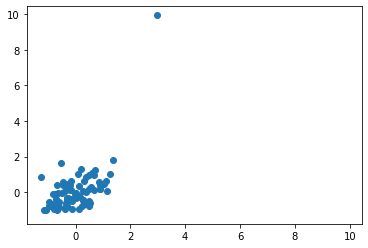

In [16]:
pred_np = pred.detach().numpy()
target_np = target.detach().numpy()

import matplotlib.pyplot as plt

plt.scatter(pred_np, target_np)
print(np.min(target_np))
min_val = np.min([np.min(pred_np), np.min(target_np)]) - 0.5
max_val = np.max([np.max(pred_np), np.max(target_np)]) + 0.5

plt.ylim(min_val, max_val)
plt.xlim(min_val, max_val)
# plt.show()

# mapping - Aug 16


In [11]:
import itertools
import numpy as np


def mapping_to_list(mappings, mode="atom"):
    """
    Given a list of mappings from products to reactants, return a representation
    (mapping expressed using a list) from reactants to products.

    Note: !!!!
        This works only for the case where there is only one item difference
        between reactants and products.

    Args:
        mappings (list of dict): mappings from products to reactants
        mode (str): `atom` or `bond`. If bond, the mapping for the broken bond is
        created. The broken bond is assumed to be the last bond in the products
        and it is mapped to the corresponding bond of the reactants.

    Returns:
        list: mapping from reactant to product. The reactant are ordered (w.r.t.
        indices). For example, a return list like [2,0,1] means:
        item 0 in reactants corresponds to item 2 in products;
        item 1 in reactants corresponds to item 0 in products; and
        item 2 in reactants corresponds to item 1 in products.

    Example:
        >>>mappings = [{0:1, 1:3}, {0:2, 1:0}]
        >>>_mapping_as_list(mappings)
        >>>[3,0,2,1]
        >>>
        >>>mappings = [{0:1, 1:3}, {0:2, 1:0}, {}]  # bond 4 not in products
        >>>_mapping_as_list(mappings)
        >>>[3,0,2,1,4]
        >>>
        >>>mappings = [{0:1, 1:4}, {0:2, 1:0}, {}]  # bond 3 not in products
        >>>_mapping_as_list(mappings)
        >>>[3,0,2,4,1]
    """

    sizes = [len(mp) for mp in mappings]
    accumulate = [i for i in itertools.accumulate(sizes)]
    accumulate = [0] + accumulate[:-1]

    # combined mapping from products to reactants
    # items in the first mapping is simply copied
    # item 0 in the second mapping has a key = len(mappings[0]) + key
    # ...
    combined_mapping = {}
    for i, mp in enumerate(mappings):
        for p, r in mp.items():
            assert p < len(mp), "product item not smaller than size"
            combined_mapping[p + accumulate[i]] = r

    # determine the missing item (in reactant) for empty mapping
    if mode == "bond":
        existing = np.concatenate([list(mp.values()) for mp in mappings])
        N = len(existing)
        expected = range(N + 1)

        for i in expected:
            if i not in existing:
                missing_item = i
                break

        # add the missing item as the last element (of products)
        combined_mapping[N] = missing_item

    # r2p mapping as a list, where the reactant item is indexed by the list index
    mp_list = sorted(combined_mapping, key=lambda k: combined_mapping[k])
    print(combined_mapping)
    return mp_list


mappings = [{0: 1, 1: 3}, {0: 2, 1: 0}]
list_map1 = mapping_to_list(mappings, mode="bond")
print(list_map1)  # [3,0,2,1]

mappings = [{0: 1, 1: 3}, {0: 2, 1: 0}, {}]  # bond 4 not in products
list_map2 = mapping_to_list(mappings, mode="bond")
print(list_map2)  # [3,0,2,1,4]

mappings = [{0: 1, 1: 4}, {0: 2, 1: 0}, {}]  # bond 3 not in products
list_map3 = mapping_to_list(mappings, mode="bond")
print(list_map3)  # [3,0,2,4,1]

{0: 1, 1: 3, 2: 2, 3: 0, 4: 4}
[3, 0, 2, 1, 4]
{0: 1, 1: 3, 2: 2, 3: 0, 4: 4}
[3, 0, 2, 1, 4]
{0: 1, 1: 4, 2: 2, 3: 0, 4: 3}
[3, 0, 2, 4, 1]


# reaction graph - aug 18


In [32]:
import pandas as pd
import networkx as nx
import numpy as np
import dgl
import copy

path_mg_data = "/home/santiagovargas/Documents/Dataset/mg_dataset/"
path_json = path_mg_data + "20220613_reaction_data.json"
mg_df = pd.read_json(path_json)

In [42]:
row = mg_df.iloc[0]
bonds_reactants = copy.deepcopy(row["reactant_bonds"])  # orignal bonds needed
bonds_products = copy.deepcopy(row["product_bonds"])  # original bonds needed
total_bonds = [tuple(bond) for bond in bonds_reactants]
[total_bonds.append(tuple(i)) for i in bonds_products]
print(total_bonds)
total_bonds = list(set(total_bonds))

print("unique reactant bonds: {}".format(len(bonds_reactants)))
print("unique product bonds: {}".format(len(bonds_products)))
print("unique total bonds: {}".format(len(total_bonds)))
print("bonds broken: {}".format(len(row["bonds_broken"])))
print("bonds formed: {}".format(len(row["bonds_formed"])))

num_bonds = len(total_bonds)
num_atoms = int(
    np.sum([v for k, v in row["composition"].items()])
)  # total number of nodes?

a2b = []
b2a = []
if num_bonds == 0:
    num_bonds = 1
    a2b = [(0, 0)]
    b2a = [(0, 0)]

else:
    a2b = []
    b2a = []
    for b in range(num_bonds):
        u = total_bonds[b][0]
        v = total_bonds[b][1]
        b2a.extend([[b, u], [b, v]])
        a2b.extend([[u, b], [v, b]])

a2g = [(a, 0) for a in range(num_atoms)]  # these are the messy ones
g2a = [(0, a) for a in range(num_atoms)]  # these are the messy ones
b2g = [(b, 0) for b in range(num_bonds)]  # these are the messy ones
g2b = [(0, b) for b in range(num_bonds)]  # these are the messy ones

edges_dict = {
    ("atom", "a2b", "bond"): a2b,
    ("bond", "b2a", "atom"): b2a,
    ("atom", "a2g", "global"): a2g,
    ("global", "g2a", "atom"): g2a,
    ("bond", "b2g", "global"): b2g,
    ("global", "g2b", "bond"): g2b,
}
self_loop = True

if self_loop:
    a2a = [(i, i) for i in range(num_atoms)]  # atom to atom nodes no mystery
    b2b = [(i, i) for i in range(num_bonds)]  # self to self
    g2g = [(0, 0)]  # global to global
    edges_dict.update(
        {
            ("atom", "a2a", "atom"): a2a,
            ("bond", "b2b", "bond"): b2b,
            ("global", "g2g", "global"): g2g,
        }
    )

g = dgl.heterograph(edges_dict)
# add name
# g.mol_name = mol.id
# if(mol.original_atom_ind!=None):
#    g.atom_ind = mol.original_atom_ind
# if(mol.original_bond_mapping != None):
#    g.bond_ind = mol.original_bond_mapping

[(0, 1), (1, 4), (2, 7), (2, 8), (2, 3), (3, 9), (3, 5), (4, 10), (4, 11), (5, 6), (0, 1), (1, 2), (1, 4), (2, 7), (2, 3), (2, 8), (3, 9), (3, 4), (3, 5), (4, 11), (4, 10), (5, 6)]
unique reactant bonds: 10
unique product bonds: 12
unique total bonds: 12
bonds broken: 0
bonds formed: 2


In [ ]:
def process_species_graph(row, classifier=False, target="ts"):
    """
    Takes a row and processes the products/reactants - entirely defined by graphs from row

    Args:
        row: the row (series) pandas object

    Returns:
        mol_list: a list of MolecularWrapper object(s) for product(s) or reactant
    """
    fail = 0
    rxn, reactant_list, product_list, bond_map = [], [], [], []
    reactant_key = "reactant"
    product_key = "product"
    reverse_rxn = False
    formed_len, broken_len = len(row["bonds_formed"]), len(row["bonds_broken"])
    check_list_len = formed_len + broken_len

    if check_list_len == 0:
        return 0
    else:
        if broken_len == 0 and formed_len == 1:
            reverse_rxn = True
            reactant_key = "product"
            product_key = "reactant"

    species_reactant = [
        int_atom(i["name"])
        for i in row[reactant_key + "_molecule_graph"]["molecule"]["sites"]
    ]
    species_products_full = [
        int_atom(i["name"])
        for i in row[product_key + "_molecule_graph"]["molecule"]["sites"]
    ]
    coords_reactant = [
        i["xyz"] for i in row[reactant_key + "_molecule_graph"]["molecule"]["sites"]
    ]
    coords_products_full = [
        i["xyz"] for i in row[product_key + "_molecule_graph"]["molecule"]["sites"]
    ]

    charge = row["charge"]
    id = str(row[reactant_key + "_id"])
    free_energy = row[product_key + "_free_energy"]
    bonds_reactant = row[reactant_key + "_bonds"]
    bonds_products = row[product_key + "_bonds"]

    # new
    total_bonds = [tuple(bond) for bond in bonds_reactant]
    [total_bonds.append(tuple(i)) for i in bonds_products]
    total_bonds = list(set(total_bonds))
    total_bonds = [list(bond) for bond in total_bonds]

    num_nodes = 0
    for i in row["composition"].items():
        num_nodes += int(i[-1])

    # will need to update once we want to generalize to more
    # than one reactant
    reactant = create_wrapper_mol_from_atoms_and_bonds(
        species_reactant,
        coords_reactant,
        bonds_reactant,
        charge=charge,
        free_energy=free_energy,
        identifier=id,
        original_atom_ind=[int(i) for i in range(num_nodes)],
        original_bond_ind=[list(i) for i in row[reactant_key + "_bonds"]],
    )
    reactant.nonmetal_bonds = row[reactant_key + "_bonds_nometal"]
    reactant_list.append(reactant)

    # handle products
    # check subgraphs first

    G = nx.Graph()
    G.add_nodes_from([int(i) for i in range(num_nodes)])
    for i in row[product_key + "_bonds"]:
        G.add_edge(i[0], i[1])
    sub_graphs = [G.subgraph(c) for c in nx.connected_components(G)]
    id = str(row[product_key + "_id"])

    # still no handling for rxns A --> B + C +....
    if len(sub_graphs) > 2:
        pass  # print("cannot handle three or more products")
    # handle A --> B + C
    elif len(sub_graphs) == 2:
        mapping, mol_prod = [], []
        for ind_sg, sg in enumerate(sub_graphs):
            dict_prod = {}
            coords_products, species_products, bond_reindex_list = [], [], []
            nodes = list(sg.nodes())
            bonds = list(sg.edges())

            # finds bonds mapped to subgraphs
            for origin_bond_ind in row[product_key + "_bonds"]:
                # check if root to edge is in node list for subgraph
                check = any(item in origin_bond_ind for item in nodes)
                if check:
                    bond_orig = nodes.index(origin_bond_ind[0])
                    bond_targ = nodes.index(origin_bond_ind[1])
                    bond_reindex_list.append([bond_orig, bond_targ])
                    # finds the index of these nodes in the reactant bonds
                    try:
                        original_bond_index = row[reactant_key + "_bonds"].index(
                            [origin_bond_ind[0], origin_bond_ind[1]]
                        )
                        dict_prod[len(bond_reindex_list) - 1] = original_bond_index
                    except:
                        print("detected bond in prod. not in react.")
            bond_map.append(dict_prod)

            for site in nodes:
                species_products.append(
                    int_atom(
                        row[product_key + "_molecule_graph"]["molecule"]["sites"][site][
                            "name"
                        ]
                    )
                )
                coords_products.append(
                    row[product_key + "_molecule_graph"]["molecule"]["sites"][site][
                        "xyz"
                    ]
                )

            # mapping_temp = {i: ind for i, ind in enumerate(nodes)}
            mapping_temp = {i: 1 for i, ind in enumerate(nodes)}

            mapping.append(mapping_temp)

            product = create_wrapper_mol_from_atoms_and_bonds(
                species_products,
                coords_products,
                bond_reindex_list,
                charge=0,
                free_energy=free_energy,
                identifier=id + "_" + str(ind_sg),
                original_atom_ind=nodes,
                original_bond_ind=[list(bond) for bond in bonds],
            )

            non_metal_products = row[product_key + "_bonds_nometal"]
            non_metal_filter = []
            for bond_non_metal in non_metal_products:
                if bond_non_metal[0] in nodes or bond_non_metal[1] in nodes:
                    non_metal_filter.append(bond_non_metal)
            product.nonmetal_bonds = non_metal_filter  # adds into non_metal
            product_list.append(product)

    else:
        dict_temp, dict_prod = {}, {}

        product = create_wrapper_mol_from_atoms_and_bonds(
            species_products_full,
            coords_products_full,
            bonds_products,
            charge=charge,
            free_energy=free_energy,
            identifier=id,
        )
        product.nonmetal_bonds = row[product_key + "_bonds_nometal"]

        # set bond mapping for one reactant w/only one product
        for ind, i in enumerate(list(product.bonds.keys())):
            try:
                key_index = list(reactant_list[0].bonds.keys()).index(i)
                dict_prod[ind] = key_index
            except:
                pass
        bond_map = [dict_prod]

        for i in range(len(species_products_full)):
            dict_temp[i] = i
        mapping = [dict_temp]

        product_list.append(product)

    if fail == 0 and product_list != [] and reactant_list != 0:
        id = [i for i in row["reaction_id"].split("-")]
        id = int(id[0] + id[1] + id[2])
        broken_bond = None

        if reverse_rxn:
            if row["bonds_formed"] != []:
                broken_bond = row["bonds_formed"][0]
        else:
            if row["bonds_broken"] != []:
                broken_bond = row["bonds_broken"][0]

        reactant_key + "_energy"
        product_key + "_energy"

        if target == "ts":
            value = row["transition_state_energy"] - row[reactant_key + "_energy"]
        else:
            value = row[product_key + "_energy"] - row[reactant_key + "_energy"]

        if classifier:
            if value <= 0.04:
                value = 0
            elif value < 0.3 and value > 0.04:
                value = 1
            elif value < 0.7 and value > 0.3:
                value = 2
            elif value < 1.5 and value > 0.7:
                value = 3
            else:
                value = 4

        rxn = Reaction(
            reactants=reactant_list,
            products=product_list,
            free_energy=value,
            broken_bond=broken_bond,
            identifier=id,
        )

        rxn.set_atom_mapping(mapping)
        rxn._bond_mapping_by_int_index = bond_map

    return rxn

In [3]:
from tqdm import tqdm

list_test = [10, 21, 21]
for ind, i in tqdm(enumerate(list_test)):
    pass

3it [00:00, 26269.13it/s]


In [8]:
list_test = [10, 21, 21]
sorted(list_test)
print(list_test)

[10, 21, 21]


In [21]:
dict_test = [
    {
        0: 0,
        1: 1,
        2: 2,
        3: 3,
        4: 4,
        5: 5,
        6: 6,
        7: 7,
        8: 8,
        9: 9,
        10: 10,
        11: 11,
        12: 12,
        13: 13,
        14: 14,
        15: 15,
        16: 16,
    },
    {0: 17},
    {0: 18, 1: 19},
]
dict_test[0].values()
[list(i.values()) for i in dict_test]
import numpy as np

list(set(list(np.concatenate([list(i.values()) for i in dict_test]).flat)))
# list_trial = [k for i, k in enumerate(dict_test[0].values]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [38]:
import torch

preds = torch.ones(10) + 1
target = torch.zeros(10)
weight = torch.ones(10)
# weight = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

from torchmetrics import MeanAbsoluteError, MeanSquaredError
from bondnet.model.metric import Metrics_WeightedMAE, Metrics_WeightedMSE

mae = MeanAbsoluteError()
mse = MeanSquaredError()
wmae = Metrics_WeightedMAE()
wmse = Metrics_WeightedMSE()

# print(mae(preds, target))
# print(wmae(preds, target, weight))
# print(mse(preds, target))
# print(torch.sqrt(wmse(preds, target, weight)))
mae.update(preds, target)
wmae.update(preds, target, weight)
mse.update(preds, target)
wmse.update(preds, target, weight)
mae.update(preds, target)
wmae.update(preds, target, weight)
mse.update(preds, target)
wmse.update(preds, target, weight)
preds = torch.ones(10) + 2
mae.update(preds, target)
wmae.update(preds, target, weight)
mse.update(preds, target)
wmse.update(preds, target, weight)
mae.update(preds, target)
wmae.update(preds, target, weight)
mse.update(preds, target)
wmse.update(preds, target, weight)

In [39]:
print(mae.compute())
print(wmae.compute())
print(mse.compute())
print(wmse.compute())

tensor(2.5000)
tensor(2.5000)
tensor(6.5000)
tensor(6.5000)


In [39]:
import pandas as pd

In [40]:
df = pd.read_json("../dataset/qm_9_hydro_merged_3.json")

In [41]:
df.shape

(11013, 51)

In [29]:
[print(i) for i in df.columns if "bonds" in i]

water_bonds
reactant_bonds
product_bonds
bonds_broken
bonds_formed
combined_product_bonds_local
combined_product_bonds_global
reactant_bonds_nometal
product_bonds_nometal
product_bonds_no_metal


[None, None, None, None, None, None, None, None, None, None]

In [35]:
df["product_bonds_nometal"] = df["combined_product_bonds_global"]
df["reactant_bonds_nometal"] = df["reactant_bonds"]

In [36]:
# overwrite df
df.to_json("../dataset/qm_9_hydro_merged_3.json")

In [3]:
file_mg_complete = "../dataset/mg_dataset/mg_qtaim_complete.json"
# read
import pandas as pd

df = pd.read_json(file_mg_complete)

In [17]:
file_mg_complete = "../dataset/mg_dataset/merged_mg.json"
# read
import pandas as pd

df_merged = pd.read_json(file_mg_complete)

In [21]:
for i in df_merged.columns:
    if "extra_feat" in i:
        print(i)

extra_feat_atom_reactant_partial_spins
extra_feat_atom_product_partial_spin
extra_feat_atom_reactant_valence_electrons
extra_feat_atom_product_valence_electrons
extra_feat_atom_reactant_total_electrons
extra_feat_atom_product_total_electrons
extra_feat_atom_reactant_s_char
extra_feat_atom_product_s_char
extra_feat_atom_reactant_p_char
extra_feat_atom_product_p_char
extra_feat_atom_reactant_d_char
extra_feat_atom_product_d_char
extra_feat_atom_reactant_f_char
extra_feat_atom_product_f_char
extra_feat_atom_reactant_elec_occ
extra_feat_atom_product_elec_occ
extra_feat_bond_reactant_1_s
extra_feat_bond_reactant_2_s
extra_feat_bond_reactant_1_p
extra_feat_bond_reactant_2_p
extra_feat_bond_reactant_1_d
extra_feat_bond_reactant_2_d
extra_feat_bond_reactant_1_f
extra_feat_bond_reactant_2_f
extra_feat_bond_reactant_1_polar
extra_feat_bond_reactant_2_polar
extra_feat_bond_reactant_occ_nbo
extra_feat_bond_reactant_indices_nbo
extra_feat_bond_product_2_s
extra_feat_bond_product_1_s
extra_feat_bond

In [18]:
df.reaction_id


# merge df and df_merged on reaction_id
df_merged_final = df_merged.merge(df, on="reaction_id", how="left")
print(df.shape)
print(df_merged.shape)
print(df_merged_final.shape)
# save to json
df_merged_final.to_json("../dataset/mg_dataset/mg_qtaim_nbo_final.json")

(5183, 172)
(5183, 110)
(5183, 281)


In [10]:
for i in df.columns:
    if "extra_feat" in i:
        print(i)

extra_feat_atom_reactant_Lagrangian_K
extra_feat_atom_product_Lagrangian_K
extra_feat_atom_reactant_Hamiltonian_K
extra_feat_atom_product_Hamiltonian_K
extra_feat_atom_reactant_e_density
extra_feat_atom_product_e_density
extra_feat_atom_reactant_lap_e_density
extra_feat_atom_product_lap_e_density
extra_feat_atom_reactant_e_loc_func
extra_feat_atom_product_e_loc_func
extra_feat_atom_reactant_ave_loc_ion_E
extra_feat_atom_product_ave_loc_ion_E
extra_feat_atom_reactant_delta_g_promolecular
extra_feat_atom_product_delta_g_promolecular
extra_feat_atom_reactant_delta_g_hirsh
extra_feat_atom_product_delta_g_hirsh
extra_feat_atom_reactant_esp_nuc
extra_feat_atom_product_esp_nuc
extra_feat_atom_reactant_esp_e
extra_feat_atom_product_esp_e
extra_feat_atom_reactant_esp_total
extra_feat_atom_product_esp_total
extra_feat_atom_reactant_grad_norm
extra_feat_atom_product_grad_norm
extra_feat_atom_reactant_lap_norm
extra_feat_atom_product_lap_norm
extra_feat_atom_reactant_eig_hess
extra_feat_atom_produ

In [1]:
# read  bson
import pandas as pd
import bson
import json

In [2]:
file_new = "../dataset/mg_dataset/rapter_clean/20230512_mpreact_assoc.bson"
with open(file_new, "rb") as f:
    data = bson.decode_all(f.read())
main_df = pd.DataFrame(data)

In [3]:
file_new = "../dataset/mg_dataset/rapter_qtaim/qtaim_out.json"
# file_new = "../dataset/mg_dataset/mg_qtaim_complete.json"
# file_new = "../dataset/mg_dataset/rapter_clean/20230512_mpreact_assoc.bson"
# with open(file_new, "rb") as f:
#    data = bson.decode_all(f.read())
# main_df = pd.DataFrame(data)
main_df = pd.read_json(file_new)

file_hydro_ts_ids = "/home/santiagovargas/Downloads/20230513_hydrolysis_ts_ids.json"
with open(file_hydro_ts_ids, "r") as f:
    hydro_ts_ids = json.load(f)
# convert file_hydro_ts_ids to list of ints
# hydro_ts_ids = [int(i) for i in hydro_ts_ids]

In [4]:
# remove repeat entries in hydro_ts_ids
hydro_ts_ids = list(set(hydro_ts_ids))
print(len(hydro_ts_ids))
hydro_ts_ids = [int(i) for i in hydro_ts_ids]

9842


In [5]:
main_df_hydro = main_df[main_df.reaction_id.isin(hydro_ts_ids)]

In [6]:
# get main_df with hydrolysis data
main_df_hydro = main_df[main_df["transition_state_id"].isin(hydro_ts_ids)]
# get main_df without hydrolysis data
main_df_no_hydro = main_df[~main_df["transition_state_id"].isin(hydro_ts_ids)]

# split main_df_hydro into 20/80 train/test
from sklearn.model_selection import train_test_split

test_df_hydro, train_df_hydro = train_test_split(
    main_df_hydro, test_size=0.8, random_state=42
)
# split main_df_no_hydro into 20/80 train/test
test_df_no_hydro, train_df_no_hydro = train_test_split(
    main_df_no_hydro, test_size=0.8, random_state=42
)

# merge test_df_no_hydro, test_df_hydro
test_df = pd.concat([test_df_no_hydro, test_df_hydro])

train_df_no_hydro.composition
# get keys of composition in every row
train_df_no_hydro.composition.apply(lambda x: x.keys())
# get only rows with Li or Mg in composition
inorganic_train_mg = train_df_no_hydro[
    train_df_no_hydro.composition.apply(lambda x: "Li" in x.keys() or "Mg" in x.keys())
]
# get only rows without Li or Mg in composition
organic_train_mg = train_df_no_hydro[
    train_df_no_hydro.composition.apply(
        lambda x: "Li" not in x.keys() and "Mg" not in x.keys()
    )
]


# merge train_df_no_hydro and train_df_hydro for full training set
train_df = pd.concat([train_df_no_hydro, train_df_hydro])
# get rows of train_df without Li or Mg in composition for full organic training set
organic_train = train_df[
    train_df.composition.apply(lambda x: "Li" not in x.keys() and "Mg" not in x.keys())
]
# print shape
print(organic_train.shape)

# print shapes
print(test_df_hydro.shape)
print(train_df_hydro.shape)
print(test_df_no_hydro.shape)
print(train_df_no_hydro.shape)
print(inorganic_train_mg.shape)
print(train_df.shape)
print(organic_train_mg.shape)
print(organic_train.shape)


# save test_df_no_hydro, test_df_hydro
test_df_no_hydro.to_json(
    "../dataset/mg_dataset/test_mg_05132023.json", default_handler=str
)
test_df_hydro.to_json(
    "../dataset/mg_dataset/test_hydro_05132023.json", default_handler=str
)
# save test_df
test_df.to_json("../dataset/mg_dataset/test_full_05132023.json", default_handler=str)
# save train_df_no_hydro, train_df_hydro
train_df_no_hydro.to_json(
    "../dataset/mg_dataset/train_mg_05132023.json", default_handler=str
)
train_df_hydro.to_json(
    "../dataset/mg_dataset/train_hydro_05132023.json", default_handler=str
)
# save inorganic_train_mg, organic_train_mg
inorganic_train_mg.to_json(
    "../dataset/mg_dataset/train_inorganic_mg_05132023.json", default_handler=str
)
organic_train_mg.to_json(
    "../dataset/mg_dataset/train_organic_mg_05132023.json", default_handler=str
)
# save organic_train
organic_train.to_json(
    "../dataset/mg_dataset/train_organic_full_05132023.json", default_handler=str
)
# save train_df
train_df.to_json("../dataset/mg_dataset/train_full_05132023.json", default_handler=str)


# save_df_to_bson(test_df_no_hydro, "../dataset/mg_dataset/test_mg_05132023.bson")

(9190, 142)
(612, 142)
(2451, 142)
(2396, 142)
(9588, 142)
(2849, 142)
(12039, 142)
(6739, 142)
(9190, 142)


In [8]:
import pandas as pd

df = "../dataset/qm_9_hydro_100.json"
df2 = "../dataset/qm_9_hydro_complete.json"
df3 = "../dataset/rev_corrected_bonds_qm_9_hydro_training.json"
df4 = "../dataset/qm9_merge_3.json"
df5 = "../dataset/mg_dataset/20210721_madeira_g2.json"
df6 = "../dataset/mg_dataset/merged_mg_small.json"
df7 = "../dataset/mg_dataset/20220613_reaction_data.json"
# open each one
df = pd.read_json(df)
df2 = pd.read_json(df2)
df3 = pd.read_json(df3)
df4 = pd.read_json(df4)
df5 = pd.read_json(df5)
df6 = pd.read_json(df6)
df7 = pd.read_json(df7)

In [10]:
df.columns

Index(['reactant_id', 'reactant_charge', 'reactant_spin_multiplicity',
       'reactant_natoms', 'reactant_elements', 'reactant_nelements',
       'reactant_composition', 'reactant_formula_alphabetical',
       'reactant_chemsys', 'reactant_symmetry', 'deprecated',
       'reactant_smiles', 'reactant_structure', 'reactant_molecule_graph',
       'water_structure', 'water_molecule_graph', 'water_bonds',
       'reactant_bonds', 'reactant_opt_energy', 'reactant_sp_energy',
       'reactant_enthalpy', 'reactant_entropy', 'product_id', 'product_smiles',
       'reaction_id', 'functional_group_reacted', 'product_structure',
       'product_molecule_graph', 'product_bonds', 'product_opt_energy',
       'product_sp_energy', 'product_enthalpy', 'product_entropy', 'dE_opt',
       'dE_sp', 'dH', 'dS', 'dG_opt', 'dG_sp', 'reaction_atom_map',
       'bonds_broken', 'bonds_formed', 'combined_reactants_graph',
       'combined_products_graph', 'mapping_dict',
       'combined_product_bonds_local', 

In [11]:
df2.columns

Index(['reactant_id', 'reactant_charge', 'reactant_spin_multiplicity',
       'reactant_natoms', 'reactant_elements', 'reactant_nelements',
       'reactant_composition', 'reactant_formula_alphabetical',
       'reactant_chemsys', 'reactant_symmetry', 'deprecated',
       'reactant_smiles', 'reactant_structure', 'reactant_molecule_graph',
       'water_structure', 'water_molecule_graph', 'water_bonds',
       'reactant_bonds', 'reactant_opt_energy', 'reactant_sp_energy',
       'reactant_enthalpy', 'reactant_entropy', 'product_id', 'product_smiles',
       'reaction_id', 'functional_group_reacted', 'product_structure',
       'product_molecule_graph', 'product_bonds', 'product_opt_energy',
       'product_sp_energy', 'product_enthalpy', 'product_entropy', 'dE_opt',
       'dE_sp', 'dH', 'dS', 'dG_opt', 'dG_sp', 'reaction_atom_map',
       'bonds_broken', 'bonds_formed', 'mapping_dict',
       'combined_reactants_graph', 'combined_products_graph',
       'combined_product_bonds_local', 

In [12]:
df3.columns

Index(['reactant_id', 'reactant_charge', 'reactant_spin_multiplicity',
       'reactant_natoms', 'reactant_elements', 'reactant_nelements',
       'reactant_composition', 'reactant_formula_alphabetical',
       'reactant_chemsys', 'reactant_symmetry', 'deprecated',
       'reactant_smiles', 'reactant_structure', 'reactant_molecule_graph',
       'water_structure', 'water_molecule_graph', 'water_bonds',
       'reactant_bonds', 'reactant_opt_energy', 'reactant_sp_energy',
       'reactant_enthalpy', 'reactant_entropy', 'product_id', 'product_smiles',
       'reaction_id', 'functional_group_reacted', 'product_structure',
       'product_molecule_graph', 'product_bonds', 'product_opt_energy',
       'product_sp_energy', 'product_enthalpy', 'product_entropy', 'dE_opt',
       'dE_sp', 'dH', 'dS', 'dG_opt', 'dG_sp', 'reaction_atom_map',
       'bonds_broken', 'bonds_formed', 'combined_reactants_graph',
       'combined_products_graph', 'mapping_dict', 'combined_reactant_bonds',
       'comb

In [13]:
df4.columns

Index(['reactant_id', 'reactant_charge', 'reactant_spin_multiplicity',
       'reactant_natoms', 'reactant_elements', 'reactant_nelements',
       'reactant_composition', 'reactant_formula_alphabetical',
       'reactant_chemsys', 'reactant_symmetry', 'deprecated',
       'reactant_smiles', 'reactant_structure', 'reactant_molecule_graph',
       'water_structure', 'water_molecule_graph', 'water_bonds',
       'reactant_bonds', 'reactant_opt_energy', 'reactant_sp_energy',
       'reactant_enthalpy', 'reactant_entropy', 'product_id', 'product_smiles',
       'reaction_id', 'functional_group_reacted', 'product_structure',
       'product_molecule_graph', 'product_bonds', 'product_opt_energy',
       'product_sp_energy', 'product_enthalpy', 'product_entropy', 'dE_opt',
       'dE_sp', 'dH', 'dS', 'dG_opt', 'dG_sp', 'reaction_atom_map',
       'bonds_broken', 'bonds_formed', 'combined_reactants_graph',
       'combined_products_graph', 'mapping_dict', 'combined_reactant_bonds',
       'comb

In [15]:
df6.columns

Index(['_id', 'builder_meta', 'charge', 'spin_multiplicity', 'natoms',
       'elements', 'nelements', 'composition', 'formula_alphabetical',
       'chemsys',
       ...
       'extra_feat_bond_product_1_polar', 'extra_feat_bond_product_2_polar',
       'extra_feat_bond_product_occ_nbo',
       'extra_feat_bond_product_indices_nbo',
       'extra_feat_atom_product_partial_charges_mulliken',
       'extra_feat_atom_product_partial_charges_resp',
       'extra_feat_atom_product_partial_charges_nbo',
       'extra_feat_atom_reactant_partial_charges_mulliken',
       'extra_feat_atom_reactant_partial_charges_resp',
       'extra_feat_atom_reactant_partial_charges_nbo'],
      dtype='object', length=106)

In [16]:
df7.columns

Index(['_id', 'builder_meta', 'charge', 'spin_multiplicity', 'natoms',
       'elements', 'nelements', 'composition', 'formula_alphabetical',
       'chemsys', 'symmetry', 'reaction_id', 'reactant_id', 'product_id',
       'transition_state_id', 'deprecated', 'reactant_structure',
       'reactant_molecule_graph', 'reactant_molecule_graph_nometal',
       'reactant_bonds', 'reactant_bonds_nometal', 'reactant_energy',
       'reactant_zpe', 'reactant_enthalpy', 'reactant_entropy',
       'reactant_free_energy', 'product_structure', 'product_molecule_graph',
       'product_molecule_graph_nometal', 'product_bonds',
       'product_bonds_nometal', 'product_energy', 'product_zpe',
       'product_enthalpy', 'product_entropy', 'product_free_energy',
       'transition_state_structure', 'transition_state_energy',
       'transition_state_zpe', 'transition_state_enthalpy',
       'transition_state_entropy', 'transition_state_free_energy', 'dE', 'dH',
       'dS', 'dG', 'dE_barrier', 'dH_barri

In [29]:
list_prod_id = df4.product_id.tolist()

In [32]:
df4.bonds_broken

0                          [[6, 8], [20, 21]]
1                          [[6, 8], [16, 17]]
2                          [[19, 20], [6, 8]]
3                          [[6, 8], [21, 22]]
4                          [[19, 20], [7, 8]]
                         ...                 
11008    [[0, 1], [19, 21], [19, 20], [1, 3]]
11009    [[0, 1], [1, 3], [21, 22], [21, 23]]
11010    [[2, 3], [21, 22], [3, 4], [21, 23]]
11011    [[6, 7], [21, 22], [5, 6], [21, 23]]
11012    [[4, 5], [5, 6], [16, 17], [16, 18]]
Name: bonds_broken, Length: 11013, dtype: object

In [4]:
import pandas as pd

path_df = "../dataset/" + "protonated_hydrolysis_reactions_complete.json"
hydro_df = pd.read_json(path_df)
# rename reactant_charge to charge
hydro_df = hydro_df.rename(columns={"reactant_charge": "charge"})
# save to json
hydro_df.to_json(
    "../dataset/" + "protonated_hydrolysis_reactions_complete.json", default_handler=str
)

In [5]:
import pandas as pd

path_df = "../dataset/" + "protonated_hydrolysis_reactions_complete.json"
hydro_df = pd.read_json(path_df)

In [6]:
hydro_df.columns

Index(['level_0', 'index', 'reactant_id', 'charge',
       'reactant_spin_multiplicity', 'reactant_natoms', 'reactant_elements',
       'reactant_nelements', 'reactant_composition',
       'reactant_formula_alphabetical', 'reactant_chemsys',
       'reactant_symmetry', 'deprecated', 'reactant_smiles',
       'reactant_structure', 'reactant_molecule_graph', 'water_structure',
       'water_molecule_graph', 'water_bonds', 'reactant_bonds',
       'reactant_opt_energy', 'reactant_sp_energy', 'reactant_enthalpy',
       'reactant_entropy', 'product_id', 'product_smiles', 'reaction_id',
       'functional_group_reacted', 'product_structure',
       'product_molecule_graph', 'product_bonds', 'product_opt_energy',
       'product_sp_energy', 'product_enthalpy', 'product_entropy', 'dE_opt',
       'dE_sp', 'dH', 'dS', 'dG_opt', 'dG_sp', 'hydronium_structure',
       'hydronium_molecule_graph', 'reaction_atom_map', 'bonds_broken',
       'bonds_formed', 'mapping_dict', 'combined_reactants_graph

In [9]:
# hydro_df.combined_product_bonds_global
# make product_bonds combined_product_bonds_global data
# hydro_df["product_bonds"] = hydro_df.combined_product_bonds_global
# drop combined_product_bonds_global
# hydro_df = hydro_df.drop(columns=["combined_product_bonds_global"])

# save to json
hydro_df.to_json(
    "../dataset/" + "protonated_hydrolysis_reactions_complete.json", default_handler=str
)

In [2]:
import pandas as pd

path_df = "../dataset/" + "qm9_merge_3.json"
hydro_df = pd.read_json(path_df)
hydro_df.shape

(11013, 54)

In [2]:
import pandas as pd
import numpy as np
from glob import glob
import subprocess
import os
import stat
import random
import bson
from copy import deepcopy

json_file = "/home/santiagovargas/dev/bondnet/bondnet/dataset/protonated_hydrolysis_reactions_complete.json"
print("reading file from: {}".format(json_file))
if json_file.endswith(".json"):
    path_json = json_file
    pandas_file = pd.read_json(path_json)
else:
    path_bson = json_file
    with open(path_bson, "rb") as f:
        data = bson.decode_all(f.read())
    pandas_file = pd.DataFrame(data)

reading file from: /home/santiagovargas/dev/bondnet/bondnet/dataset/protonated_hydrolysis_reactions_complete.json


In [14]:
for ind, row in pandas_file[0:10].iterrows():
    # reactants
    reactants = row["combined_reactants_graph"]
    # reactants = row["reactant_molecule_graph"]
    products = row["combined_products_graph"]
    # products = row["product_molecule_graph"]

    atoms = int(len(reactants["molecule"]["sites"]))
    atoms_r = deepcopy(atoms)
    print(reactants["molecule"]["sites"])
    print(products["molecule"]["sites"])
    for ind in range(atoms):
        xyz = reactants["molecule"]["sites"][ind]["xyz"]
        atom = reactants["molecule"]["sites"][ind]["species"][0]["element"]
        print(atom, xyz[0], xyz[1], xyz[2])
    print("*" * 20)
    atoms = int(len(products["molecule"]["sites"]))
    atoms_p = deepcopy(atoms)
    if int(atoms_r) != int(atoms_p):
        print(atoms_r, atoms_p)

    for ind in range(atoms):
        xyz = products["molecule"]["sites"][ind]["xyz"]
        atom = products["molecule"]["sites"][ind]["species"][0]["element"]
        print(atom, xyz[0], xyz[1], xyz[2])
    print("-" * 20)

[{'name': 'N', 'species': [{'element': 'N', 'occu': 1}], 'xyz': [1.1361002324, 0.3922277033, 0.405828034], 'properties': {}}, {'name': 'C', 'species': [{'element': 'C', 'occu': 1}], 'xyz': [2.2617473513, 0.1468219007, 0.2950267672], 'properties': {}}, {'name': 'C', 'species': [{'element': 'C', 'occu': 1}], 'xyz': [3.6821074077000002, -0.16312284, 0.1500444655], 'properties': {}}, {'name': 'C', 'species': [{'element': 'C', 'occu': 1}], 'xyz': [3.9780955751000002, -0.9060814894, -1.1624628103], 'properties': {}}, {'name': 'O', 'species': [{'element': 'O', 'occu': 1}], 'xyz': [3.4932660457, -0.060054047000000006, -2.209839701], 'properties': {}}, {'name': 'C', 'species': [{'element': 'C', 'occu': 1}], 'xyz': [5.5043958718, -1.0116454929, -1.3282195661], 'properties': {}}, {'name': 'O', 'species': [{'element': 'O', 'occu': 1}], 'xyz': [6.1713962444, -1.5440287172, -0.1949910589], 'properties': {}}, {'name': 'C', 'species': [{'element': 'C', 'occu': 1}], 'xyz': [3.2461112366, -2.2372691767,

In [17]:
path_df = "../dataset/" + "protonated_full_v2.json"
hydro_df = pd.read_json(path_df)

In [18]:
# hydro_df.combined_product_bonds_global
# make product_bonds combined_product_bonds_global data
hydro_df["product_bonds"] = hydro_df.combined_product_bonds_global
# drop combined_product_bonds_global
hydro_df = hydro_df.drop(columns=["combined_product_bonds_global"])

# save to json
hydro_df.to_json("../dataset/" + "protonated_full_v2.json", default_handler=str)

In [10]:
import pandas as pd

path_df = "../dataset/" + "qm_9_merge_3_final.json"
hydro_df = pd.read_json(path_df)
hydro_df["product_bonds"] = hydro_df.combined_product_bonds_global
hydro_df.product_molecule_graph = hydro_df.combined_products_graph
hydro_df.to_json("../dataset/" + "qm_9_merge_3_final.json", default_handler=str)

In [11]:
hydro_df.shape

(11013, 54)